# PreProcessing Conversational Data to enable a conversational core model

- **Authors:** Riyaadh Gani and Damilola Ogunleye
- **Project:** Food Recognition & Recipe LLM  
- **Purpose:** Fine-tuning pipeline for our base model for conversational abilities

---

## Overview

This notebook converts the Open Assistant 1 (OASST1) dataset into training data for our core-model. 
The OASST1 data contains a flat list of some human-written responses which we can filter by language and quality. This notebook helps convert them back to their hierarchical tree structure which can be in turn be parsed as multi-turn assistant, user dialogue with the prior conversation kept as context. This schema also enables RAG retrieved documents to be stored in the context field as well.

**Output:** Conversational dataset for training and validation:

- Example structure of the data it contains in [samples.txt](./data/processed/oasst1_multiturn_en/samples.txt)

In [58]:
%pip install transformers torch datasets tqdm matplotlib pandas

  Using cached matplotlib-3.10.7-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp310-cp310-macosx_10_9_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp310-cp310-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl (253 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp310-cp310-macosx_10_9_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.9-cp310-cp310-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-12.0.0-cp310-cp310-macosx_11_0_arm64.whl (4.7 MB)
Using cached pyparsing-3.2.5-p

In [ ]:
import pandas as pd
from datasets import load_dataset, load_from_disk, Dataset
from collections import defaultdict
from typing import List, Dict, Any
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

usingColab = False  # Set to True if using Google Colab

In [ ]:
if usingColab:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Colab connected to Google Drive")
    
    # Base project directory in Google Drive
    PROJECT_DIR = Path("/content/drive/MyDrive/cooking-assistant-project")

    # Create directories if they don't exist
    (PROJECT_DIR / "data" / "raw").mkdir(parents=True, exist_ok=True)
    (PROJECT_DIR / "data" / "processed").mkdir(parents=True, exist_ok=True)
    (PROJECT_DIR / "models").mkdir(parents=True, exist_ok=True)

    # Change working directory
    os.chdir(PROJECT_DIR)

    print(f"✓ Working directory: {os.getcwd()}")
    print(f"✓ Project structure ready")

    # Verify structure
    print("\nDirectory structure:")
    for path in [PROJECT_DIR / "data" / "raw", 
                PROJECT_DIR / "data" / "processed",
                PROJECT_DIR / "models"]:
        print(f"  {'✓' if path.exists() else '✗'} {path}")

### Download Conversational Dataset for fine-tuning

Alternative dataset would be the Alpaca dataset which is intended for single-turn data not necessarily multi-turn. This means it is good for following a single, direct instruction while we want our model to be a bit more conversational. The OASST1 is human-generated while Alpaca is synthetic (created by GPT-3.5),

In [ ]:
# Load OpenAssistant dataset
dataset = load_dataset("OpenAssistant/oasst1")

# Save locally
dataset.save_to_disk("./data/raw/oasst1")
print(f"Dataset saved: {len(dataset['train'])} training examples")

/Users/dogun/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Robotics and AI MEng/Year 3/deep learning/deeplearn3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (1/1 shards): 100%|██████████| 4401/4401 [00:00<00:00, 221925.92 examples/s]

Dataset saved: 84437 training examples


## Format the training data

Training data will be formed as the following with the conversation history and any retrieved documents saved as context.

In [4]:
CONVERSATIONAL_TEMPLATE = """The following is a conversation between a user and a helpful cooking assistant.

{context}

User: {user_input}
Assistant: {response}"""

# Preview the template
print("Prompt Template:")
print("="*70)
print(CONVERSATIONAL_TEMPLATE.format(
    context="",
    user_input="How do I make pasta?",
    response="To make pasta from scratch..."
))

Prompt Template:
The following is a conversation between a user and a helpful cooking assistant.



User: How do I make pasta?
Assistant: To make pasta from scratch...


In [62]:

# Load the dataset from disk
dataset_on_disk = load_from_disk("./data/raw/oasst1")

train_df = dataset_on_disk['train'].to_pandas()
val_df = dataset_on_disk['validation'].to_pandas()

df = pd.concat([train_df, val_df], ignore_index=True)

print(f"Loaded {len(df):,} total messages")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst message:")
print(df.iloc[0][['text', 'role', 'lang']])
print(df.iloc[0]['text'])  # Print the text of the first message

Loaded 88,838 total messages
Columns: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels']

First message:
text    Can you write a short introduction about the r...
role                                             prompter
lang                                                   en
Name: 0, dtype: object
Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.


In [63]:
# Confirm null values in parent_id column
def confirm_null_values(df: pd.DataFrame):
    null_counts = df['parent_id'].isnull().sum()
    print("Null counts in parent_id column:")
    print(null_counts)


#### Apply Filters

Filtering for:
- English Only
- messages w/o NaN
- rank when it is the assistant not the prompter

In [64]:
# Apply Filters

original_len = len(df)

# Language filter - only English
df = df[df['lang'] == 'en']
print(f"  Language filter (en): {len(df):,} messages ({len(df)/original_len*100:.1f}%)")

# Quality filter - only highest ranked
df = df[(df['role'] == 'prompter') | (df['role'] == 'assistant') & (df['rank'] == 0)]
print(f"  Quality filter (rank 0 or prompter): {len(df):,} messages ({len(df)/original_len*100:.1f}%)")

# Remove deleted messages
df = df[~df['deleted']]
print(f"  Deleted messages removed: {len(df):,} messages ({len(df)/original_len*100:.1f}%)")

print(f"\n Filtered to {len(df):,} high-quality English messages")


null_counts = df.isnull().sum()
print("Null counts per column:")
print(null_counts)

  Language filter (en): 41,305 messages (46.5%)
  Quality filter (rank 0 or prompter): 24,253 messages (27.3%)
  Deleted messages removed: 23,963 messages (27.0%)

 Filtered to 23,963 high-quality English messages
Null counts per column:
message_id             0
parent_id           3670
user_id                0
created_date           0
text                   0
role                   0
lang                   0
review_count           0
review_result          9
deleted                0
rank               15708
synthetic              0
model_name         23963
detoxify               3
message_tree_id        0
tree_state             0
emojis              4221
labels                 4
dtype: int64


### Build Conversation Trees 
OASST1 contains nested answer-response chains which we will leverage to add conversation history as context. We have to reconstruct them based on the children node ids

In [65]:
def extract_paths(node_id: str, 
                  children: Dict[str, List[str]], 
                  messages: Dict[str, Dict[str, Any]], 
                  current_path: List[Dict[str, Any]] = None) -> List[List[Dict[str, Any]]]:
    """
    Recursively extract all paths from node to leaves.

    Args:
        node_id: Current node ID.
        children: Mapping of parent IDs to list of child IDs.
        messages: Mapping of message IDs to message data.
        current_path: Current path being built.
    Returns:
        List of all paths from current node to leaves.
    """
    if current_path is None:
        current_path = []
    
    # Add current node to path
    current_path = current_path + [messages[node_id]]
    
    # If leaf node, return the path
    if node_id not in children or len(children[node_id]) == 0:
        return [current_path]
    
    # Otherwise, explore all children
    all_paths = []
    for child_id in children[node_id]:
        child_paths = extract_paths(child_id, children, messages, current_path)
        all_paths.extend(child_paths)
    
    return all_paths

In [66]:
def build_conversation_paths(df: pd.DataFrame) -> List[List[Dict[str, Any]]]:
    """
    Build all conversation paths from OASST1 tree structure.
    """
    # Group by conversation tree (finds the related message chains)
    trees = df.groupby('message_tree_id')
    all_paths = []
    
    print(f"Processing {len(trees):,} conversation trees...")
    
    for tree_id, tree_df in tqdm(trees, desc="Building paths"):
        # Build parent-child mapping
        children = defaultdict(list)        # parent_id: list of child_ids
        messages = {}                       # dictionary mapping message_id to message content
        
        for _, row in tree_df.iterrows():
            # extraact message and parent ids and add to the tree structure
            msg_id = row['message_id']
            parent_id = row['parent_id']
            messages[msg_id] = row.to_dict()
            
            if pd.notna(parent_id):
                children[parent_id].append(msg_id)
        
        # Find root (message with no parent)
        roots = [msg_id for msg_id in messages.keys() 
                 if pd.isnull(messages[msg_id]['parent_id'])]
        
        # Extract all paths from root to leaves
        for root in roots:
            paths = extract_paths(root, children, messages)
            all_paths.extend(paths)
    
    return all_paths

Build the conversation paths (break down hierarchical tree to chain)

In [67]:
paths = build_conversation_paths(df)

print(f"\n✓ Extracted {len(paths):,} conversation paths")
print(f"\nPath length distribution:")
path_lengths = pd.Series([len(p) for p in paths])
print(path_lengths.describe())

Processing 3,692 conversation trees...


Building paths: 100%|██████████| 3692/3692 [00:01<00:00, 3500.41it/s]



✓ Extracted 4,176 conversation paths

Path length distribution:
count    4176.000000
mean        3.208094
std         0.896055
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
dtype: float64


#### Display example paths

In [68]:
def display_conversation_path(path, max_length=200):
    """Display a conversation path in a readable format"""
    print("="*70)
    for i, msg in enumerate(path):
        role = "USER" if msg['role'] == 'prompter' else "ASSISTANT"
        text = msg['text']
        if len(text) > max_length:
            text = text[:max_length] + "..."
        print(f"{role} (turn {i+1}): {text}")
        print()

# Show first 2 paths
print("Sample Conversation Path 1:")
display_conversation_path(paths[0])

print("\nSample Conversation Path 2:")
display_conversation_path(paths[1])

Sample Conversation Path 1:
USER (turn 1): Do you have any information about the Commodore 64?

ASSISTANT (turn 2): Of course. The Commodore 64 is a 8-bit home computer that was released by Commodore International in August 1982. It is one of the most successful home computers of all time, with over 17 million unit...


Sample Conversation Path 2:
USER (turn 1): Who was Socrates and when did he die?

ASSISTANT (turn 2): Socrates was a Greek philosopher who lived in Athens from around 470/469 BC to 399 BC. He is considered one of the most important figures in Western philosophy and is credited as being one of the foun...



### Format training data with History

Convert paths into training examples, with conversation history as the context

In [69]:
def format_history(history: List[Dict[str, Any]]) -> str:
    """
    Format conversation history for context field.
    """
    # If no history retrun an empty string
    if not history:
        return ""
    
    # Include previous conversations for context with this preamble
    formatted = "Previous conversation:\n"
    for msg in history:
        role = "User" if msg['role'] == 'prompter' else "Assistant"
        # Truncate very long messages
        text = msg['text']
        if len(text) > 500:
            text = text[:497] + "..."
        formatted += f"{role}: {text}\n"
    
    return formatted.strip()


def format_with_history(paths: List[List[Dict[str, Any]]]) -> List[Dict[str, str]]:
    """
    Convert conversation paths to training examples with history.
    """
    training_examples = []
    
    print(f"Formatting {len(paths):,} conversation paths...")
    
    for path in tqdm(paths, desc="Formatting"):
        conversation_history = []
        
        for i, message in enumerate(path):
            # Only create training examples for assistant responses
            if message['role'] == 'assistant':
                # Find the prompter message this responds to
                if i > 0 and path[i-1]['role'] == 'prompter':
                    user_input = path[i-1]['text']
                    response = message['text']
                    
                    # Build context from conversation history
                    context = ""
                    if len(conversation_history) > 0:
                        context = format_history(conversation_history)
                    
                    # Format with template
                    formatted_text = CONVERSATIONAL_TEMPLATE.format(
                        user_input=user_input,
                        context=context,
                        response=response
                    )
                    
                    training_examples.append({
                        "text": formatted_text,
                        "user_input": user_input,
                        "response": response,
                        "context": context,
                        "turn_number": len(conversation_history) // 2 + 1,
                        "has_history": len(conversation_history) > 0
                    })
            
            # Add to history
            conversation_history.append(message)
    
    return training_examples

In [70]:
# Format the training data
training_data = format_with_history(paths)

print(f"\n✓ Created {len(training_data):,} training examples")

Formatting 4,176 conversation paths...


Formatting: 100%|██████████| 4176/4176 [00:00<00:00, 48904.43it/s]


✓ Created 5,711 training examples


Analyse the created dataset

Dataset Statistics:
Total examples: 5,711

Examples with conversation history: 5,711 (100.0%)
Examples without history (first turn): 0 (0.0%)


Examples by Turn Number:
turn_number
1    4160
2    1537
3      14
Name: count, dtype: int64


Text Length Statistics:
  Mean: 1524 characters
  Median: 1387 characters
  Max: 12049 characters
  Min: 145 characters


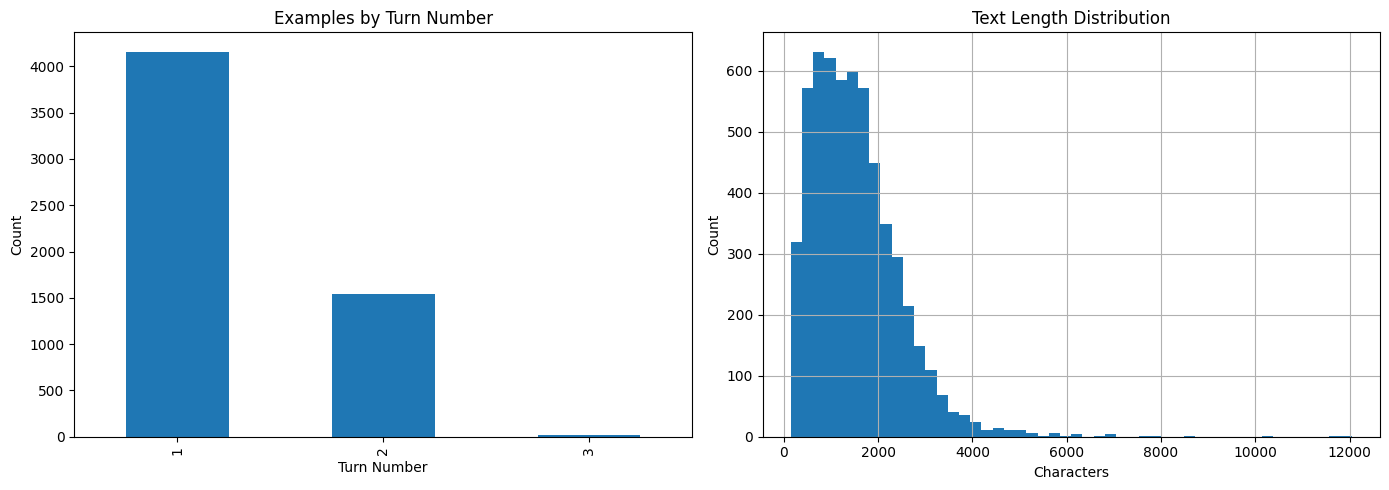

In [71]:
# Convert to DataFrame for easier analysis
analysis_df = pd.DataFrame(training_data)

print("Dataset Statistics:")
print("="*70)
print(f"Total examples: {len(analysis_df):,}")
print(f"\nExamples with conversation history: {analysis_df['has_history'].sum():,} ({analysis_df['has_history'].mean()*100:.1f}%)")
print(f"Examples without history (first turn): {(~analysis_df['has_history']).sum():,} ({(~analysis_df['has_history']).mean()*100:.1f}%)")

print("\n\nExamples by Turn Number:")
print(analysis_df['turn_number'].value_counts().sort_index())

print("\n\nText Length Statistics:")
text_lengths = analysis_df['text'].str.len()
print(f"  Mean: {text_lengths.mean():.0f} characters")
print(f"  Median: {text_lengths.median():.0f} characters")
print(f"  Max: {text_lengths.max():.0f} characters")
print(f"  Min: {text_lengths.min():.0f} characters")

# Plot distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Turn number distribution
analysis_df['turn_number'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Examples by Turn Number')
axes[0].set_xlabel('Turn Number')
axes[0].set_ylabel('Count')

# Text length distribution
text_lengths.hist(bins=50, ax=axes[1])
axes[1].set_title('Text Length Distribution')
axes[1].set_xlabel('Characters')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Show sample training examples

In [72]:
def display_training_example(example):
    """Display a training example in a readable format"""
    print("="*70)
    print(f"TURN {example['turn_number']} | HAS HISTORY: {example['has_history']}")
    print("="*70)
    print(example['text'])
    print("="*70)

# Show examples from different turns
print("\n📝 Example 1: First Turn (No History)")
first_turn_examples = [ex for ex in training_data if ex['turn_number'] == 1]
display_training_example(first_turn_examples[0])

print("\n📝 Example 2: Second Turn (With History)")
second_turn_examples = [ex for ex in training_data if ex['turn_number'] == 2]
if second_turn_examples:
    display_training_example(second_turn_examples[0])

print("\n📝 Example 3: Third Turn (With More History)")
third_turn_examples = [ex for ex in training_data if ex['turn_number'] == 3]
if third_turn_examples:
    display_training_example(third_turn_examples[0])


📝 Example 1: First Turn (No History)
TURN 1 | HAS HISTORY: True
The following is a conversation between a user and a helpful cooking assistant.

Previous conversation:
User: Do you have any information about the Commodore 64?

User: Do you have any information about the Commodore 64?
Assistant: Of course. The Commodore 64 is a 8-bit home computer that was released by Commodore International in August 1982. It is one of the most successful home computers of all time, with over 17 million units sold. It featured 64 kilobytes of RAM, color graphics, and the SID sound chip. It was widely used for gaming, programming, and home productivity applications. It was succeeded by the Commodore 128.

There is still a thriving community of Commodore 64 enthusiasts around the world who continue to enjoy playing and programming on the system. You can find more information about the Commodore 64 on various websites and forums dedicated to the system.

If you have any specific questions about the Commo

### Create HuggingFace Dataset

In [73]:
print("Creating HuggingFace Dataset...")

# Convert to HuggingFace Dataset
hf_dataset = Dataset.from_list(training_data)

print(f"✓ Created dataset with {len(hf_dataset):,} examples")
print(f"  Features: {list(hf_dataset.features.keys())}")

Creating HuggingFace Dataset...
✓ Created dataset with 5,711 examples
  Features: ['text', 'user_input', 'response', 'context', 'turn_number', 'has_history']


In [74]:
print("\nSplitting into train/validation sets...")
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=43)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"✓ Train set: {len(train_dataset):,} examples")
print(f"✓ Validation set: {len(val_dataset):,} examples")


Splitting into train/validation sets...
✓ Train set: 5,139 examples
✓ Validation set: 572 examples


#### Save the processed Datasets

In [ ]:
if usingColab:
    output_dir = PROJECT_DIR / "data" / "processed" / "oasst1_multiturn_en"
else:
    output_dir = Path("./data/processed/oasst1_multiturn_en")
    
train_path = output_dir / "train"
val_path = output_dir / "val"

# Create directories
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving datasets to {output_dir}...")

# Save datasets
train_dataset.save_to_disk(str(train_path))
val_dataset.save_to_disk(str(val_path))

print(f"✓ Train dataset saved to: {train_path}")
print(f"✓ Validation dataset saved to: {val_path}")

Saving datasets to data/processed/oasst1_multiturn_en...


Saving the dataset (1/1 shards): 100%|██████████| 572/572 [00:00<00:00, 26723.05 examples/s]

✓ Train dataset saved to: data/processed/oasst1_multiturn_en/train
✓ Validation dataset saved to: data/processed/oasst1_multiturn_en/val


#### Examples to understand the data

In [76]:
samples_path = output_dir / "samples.txt"

print(f"\nSaving sample examples to {samples_path}...")

with open(samples_path, 'w', encoding='utf-8') as f:
    # Save 10 examples from different turns
    f.write("OASST1 TRAINING DATA SAMPLES\n")
    f.write("="*70 + "\n\n")
    
    for turn in [1, 2, 3, 4, 5]:
        turn_examples = [ex for ex in training_data if ex['turn_number'] == turn]
        if turn_examples:
            f.write(f"\n{'='*70}\n")
            f.write(f"TURN {turn} EXAMPLES\n")
            f.write(f"{'='*70}\n\n")
            
            # Save 2 examples per turn
            for i, ex in enumerate(turn_examples[:2], 1):
                f.write(f"--- Example {i} ---\n")
                f.write(ex['text'])
                f.write("\n\n")

print(f"✓ Saved sample examples")


Saving sample examples to data/processed/oasst1_multiturn_en/samples.txt...
✓ Saved sample examples
